In [114]:
#%%capture

#!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'
#!pip install transformers
from fhnw.nlp.utils.processing import parallelize_dataframe
from fhnw.nlp.utils.processing import is_iterable
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.storage import save_dataframe
from fhnw.nlp.utils.storage import load_dataframe
import pandas as pd
import numpy as np
import re
import tqdm
from datetime import datetime
#from transformers import AutoTokenizer, TFAutoModel
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
#from transformers import BertTokenizer, TFBertModel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import re
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from fhnw.nlp.utils.preprocess import preprocess
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score ,precision_score, make_scorer, recall_score
tqdm.tqdm.pandas()
sns.set_style('whitegrid')

pd.options.display.max_colwidth = 600
pd.options.display.max_rows = 400


Laden der Daten

In [115]:
file = "data/german_news_articles_original_train.parq"
download("https://drive.switch.ch/index.php/s/mRnuzx4BLpMLqyz/download", file)
data_train = load_dataframe(file)

file = "data/german_news_articles_original_test.parq"
download("https://drive.switch.ch/index.php/s/DKUnZraeGp3EIK3/download", file)
data_test = load_dataframe(file)


data_train["split"] = "train"
data_test["split"] = "test"
data_all = pd.concat([data_train, data_test])
data = data_train

In [116]:
data_all = data_all.drop(["text"], axis=1, errors='ignore')

In [117]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_code = le.fit(data_train['label'].drop_duplicates())
#y_train 

In [118]:
label = pd.DataFrame(data_train['label'].drop_duplicates(inplace=False))
label.reset_index(inplace = True, drop = True)
label

,label
0,Sport
1,Kultur
2,Web
3,Wirtschaft
4,Inland
5,Etat
6,International
7,Panorama
8,Wissenschaft


Vorbereiten der Daten und kurzer check der längen.

In [119]:
def clean_text(text, keep_punctuation=False):
    """Cleans text by removing html tags, non ascii chars, digits and optionally punctuation"""



    # Compile RE pattern for HTTPS address, then Substitute it for blank
    RE_HTTPS = re.compile(r"https?://\S+ ")
    text = re.sub(RE_HTTPS, "", text)

    # Subsitute twitter picutures for blank
    text = re.sub(r'pic.twitter.com/[\w]*',"", text)

    # Subsitute multiple points space for 1 point
    text = re.sub(r"\(?[.][.]+\)?", ".", text)

    # Compile RE pattern for HTML tags, then Substitute it for blank
    RE_TAGS = re.compile(r"<[^>]+>")
    text = re.sub(RE_TAGS, " ", text)

    # Compile RE patterns for general text, including punctuation rule
    if keep_punctuation:
        RE_ASCII = re.compile(r"[^a-züöä,.!?]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[a-züöä,.!?]\b", re.IGNORECASE)
    else:
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

    # keep only ASCII + European Chars and whitespace, no digits
    text = re.sub(RE_ASCII, " ", text)
    # convert all whitespaces (tabs etc.) to single wspace
    text = re.sub(RE_SINGLECHAR, " ", text)

    # Subsitute multiple blank space for 1 blank space
    text = re.sub(r"\s+", " ", text)

    # Subsitute double punctuation (left-over after previous subsitutions) for 1 point
    text = re.sub(r" [.,]+ [,.]+", ".", text)

    return text

In [120]:
X_train = data['text_original'] #.apply(clean_text, keep_punctuation = True) -> getestet, gibt schlechtere Resultate
X_test = data_test['text_original'] #.apply(clean_text, keep_punctuation = True)-> getestet, gibt schlechtere Resultate
y_train = label_code.transform(data['label'])
y_true = label_code.transform(data_test['label'])
print(len(y_train),len(y_true), len(X_test))


9245 1028 1028


Der untere Code importiert das stopwords-Korpus aus dem Natural Language Toolkit (NLTK) und lädt die erforderlichen Ressourcen für deutsche Stoppwörter herunter. Anschließend erstellt er eine Menge deutscher Stoppwörter und speichert sie in der Variablen stopwords.

# Tensorflow Baseline

In [121]:
vocab_size = 10000
BATCH_SIZE = 32
EPOCHS = 12
LEARNING_RATE = 1e-5
NEURON = 2**5


In [122]:
tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8',
)
"""
count_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count'
)

count_vectorizer.adapt(X_train.values)


tfidf_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf-idf',
    ngrams=(2, 3)
)
tfidf_vectorizer.adapt(X_train.values)
# Define the neural network architecture
model = tf.keras.Sequential([
    tfidf_vectorizer,
    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
"""

"\ncount_vectorizer = tf.keras.layers.TextVectorization(\n    max_tokens=vocab_size,\n    output_mode='count'\n)\n\ncount_vectorizer.adapt(X_train.values)\n\n\ntfidf_vectorizer = tf.keras.layers.TextVectorization(\n    max_tokens=vocab_size,\n    output_mode='tf-idf',\n    ngrams=(2, 3)\n)\ntfidf_vectorizer.adapt(X_train.values)\n# Define the neural network architecture\nmodel = tf.keras.Sequential([\n    tfidf_vectorizer,\n    tf.keras.layers.Dense(32, activation='relu', input_shape=(vocab_size,)),  # Hidden layer with ReLU activation\n    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification\n])\n\n# Compile the model\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.summary()\n"

In [123]:
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train))
                    .shuffle(buffer_size=len(X_train.values), reshuffle_each_iteration=True)
                    .repeat(EPOCHS)
                    .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test.values, y_true))
                    .batch(BATCH_SIZE))

In [124]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(data_all["label"])
y_true=label_binarizer.transform(data_test['label'])

Nur so aus Intresse mal noch 2 Layer hinzugefügt, um zu sehen wie das Netzwerk reagiert. Irgendwie kann ich nicht glauben das wir mit so einem Netwerk schon nahe an xgb boost sind... vielleicht irgendwo en Fehler...

In [125]:
count_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='count'
)



count_vectorizer.adapt(X_train.values)


model = tf.keras.Sequential([
    count_vectorizer,
    tf.keras.layers.Dense(NEURON, activation='relu', input_shape=(vocab_size,)),
    tf.keras.layers.Dense(NEURON, activation='relu', input_shape=(vocab_size,)),
    tf.keras.layers.Dense(NEURON, activation='relu', input_shape=(vocab_size,)),   # Hidden layer with ReLU activation
    tf.keras.layers.Dense(9, activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_18 (Tex  (None, 10000)             0         
 tVectorization)                                                 
                                                                 
 dense_30 (Dense)            (None, 64)                640064    
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                                 
 dense_33 (Dense)            (None, 9)                 585       
                                                                 
Total params: 648969 (2.48 MB)
Trainable params: 648969 (2.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [126]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=EPOCHS,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/12


3467/3467 [==============================] - 58s 16ms/step - loss: 0.1371 - accuracy: 0.9607 - val_loss: 1.4022 - val_accuracy: 0.8045
Epoch 2/12
3467/3467 [==============================] - 60s 17ms/step - loss: 0.0109 - accuracy: 0.9972 - val_loss: 1.2050 - val_accuracy: 0.8054
Epoch 3/12
3467/3467 [==============================] - 63s 18ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 1.2970 - val_accuracy: 0.8307
Epoch 4/12
3467/3467 [==============================] - 67s 19ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 1.1681 - val_accuracy: 0.8444
Epoch 5/12
3467/3467 [==============================] - 68s 20ms/step - loss: 9.3674e-04 - accuracy: 0.9996 - val_loss: 1.3818 - val_accuracy: 0.8395
Epoch 6/12
3467/3467 [==============================] - 68s 20ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 1.3279 - val_accuracy: 0.8356
Epoch 7/12
3467/3467 [==============================] - 69s 20ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 1.4744 - val_ac

<AxesSubplot: xlabel='epoch'>

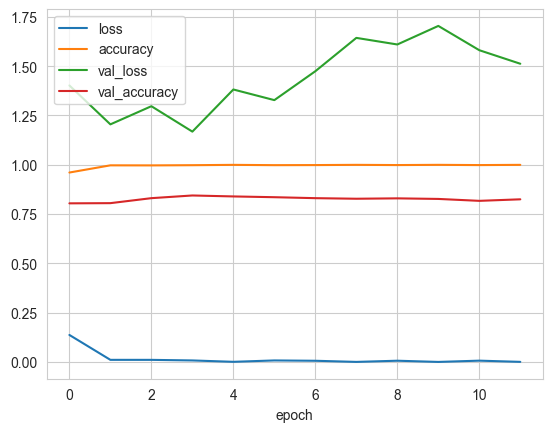

In [127]:
history_df = pd.DataFrame({'epoch': history.epoch, **history.history}).set_index('epoch')
history_df.plot()

In [128]:
result = model.predict(X_test.values)

33/33 [==============================] - 1s 11ms/step


In [129]:
result = result > .5
y_pred = result.astype(int)
conf = multilabel_confusion_matrix(y_true, y_pred)
conf

array([[[936,  25],
        [ 19,  48]],

       [[906,  20],
        [ 24,  78]],

       [[859,  18],
        [ 25, 126]],

       [[962,  12],
        [ 13,  41]],

       [[836,  24],
        [ 41, 127]],

       [[906,   2],
        [  6, 114]],

       [[844,  16],
        [ 25, 143]],

       [[862,  25],
        [ 33, 108]],

       [[956,  15],
        [  5,  52]]], dtype=int64)

Accuracy: 0.8239299610894941
F1-Score: 0.8271433111185562
Recall: 0.828277902157589
Precision: 0.830353919085406

In [130]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

Accuracy: 0.8142023346303502
F1-Score: 0.816699470641309
Recall: 0.8122445715398255
Precision: 0.8237084766974172


In [131]:
result = model.predict(X_test.values)
result = result > .5
y_pred = result.astype(int)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred,average='macro')
#roc_auc = roc_auc_score(y_true, y_pred, average='ovs')
prec = precision_score(y_true, y_pred,average='macro')
rec = recall_score(y_true, y_pred,average='macro')
print('Accuracy:', acc)
print('F1-Score:', f1)
#print('ROC-AUC:', roc_auc)
print('Recall:', rec)
print('Precision:', prec)

 1/33 [..............................] - ETA: 1s

33/33 [==============================] - 0s 11ms/step
Accuracy: 0.8142023346303502
F1-Score: 0.816699470641309
Recall: 0.8122445715398255
Precision: 0.8237084766974172


# Fazit
Sowohl mit einfachen Neuralen Netzenohne Regulierung, wie auch mit dem XGB classifier ist ein F1-Score von 83% machbar. Habe bei diesem Notebook sehr viel gelernt. Ich hatte mich gleich auf Bertmodell etc. gestürtzt und hatte wenig Grundlagenwissen, als ich mit dem Projekt angefangen habe. Durch die Grundlagen und Computervision Prüfung musste ich mir das wissen aneignen, was mir hier kurz vor Abgabe nochmals enormer Lerneffekt gegeben hat. Ich habe sehr viele Bertmodelle versucht zu optimieren, bin aber nie über F1 von 90% gekommen. Bin gespannt was ich ich mit Regulierung in der kurzen Zeit noch schaffe aus den Basline Netzwerken zu holen.


